In [13]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [14]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [35]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import and_

In [36]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [37]:
# reflect an existing database into a new model
sql_base = automap_base()
# reflect the tables
sql_base.prepare(autoload_with=engine)

In [38]:
# View all of the classes that automap found
sql_base.classes.keys()

['station', 'measurement']

In [39]:
# Save references to each table
Station = sql_base.classes.station
Measurement = sql_base.classes.measurement

In [40]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [41]:
# Find the most recent date in the data set.
most_recent_date_row = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date_str = most_recent_date_row.date
most_recent_date = datetime.strptime(most_recent_date_str, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

print(most_recent_date)
print(one_year_ago)

2017-08-23 00:00:00
2016-08-23 00:00:00


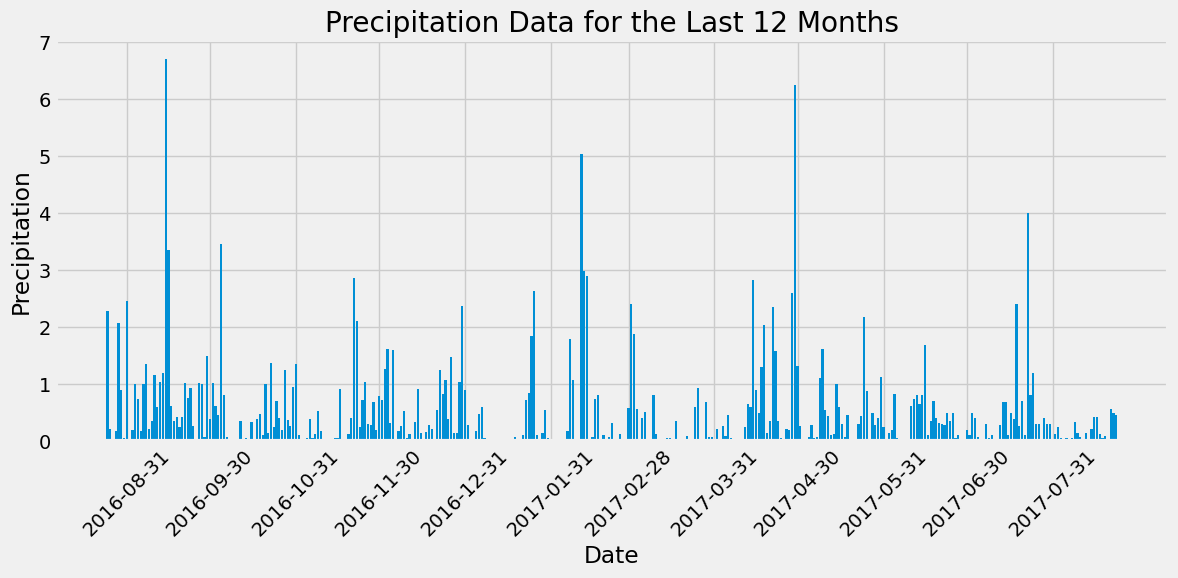

In [42]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Perform a query to retrieve the data and precipitation scores
query = sqlalchemy.text(f"SELECT date, prcp FROM Measurement WHERE date >= :one_year_ago")
results = session.execute(query, {'one_year_ago': one_year_ago})

#dictionary to store data
data = {'date': [], 'precipitation': []}

#get data from query results
for row in results:
    data['date'].append(row[0])
    data['precipitation'].append(row[1])

#create dataframe
df = pd.DataFrame(data)

#sort by date
df = df.sort_values(by='date')

#convert 'date' to datetime object
df['date'] = pd.to_datetime(df['date'])

#filter df
df_filtered = df[(df['date'] >= one_year_ago) & (df['date'] <= most_recent_date)]

#plot data
plt.figure(figsize=(12, 6))
plt.bar(df_filtered['date'], df_filtered['precipitation'])
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Precipitation Data for the Last 12 Months')
plt.xticks(rotation=45)

date_range = pd.date_range(start=one_year_ago, end=most_recent_date, freq='M')
plt.xticks(date_range, [date.strftime('%Y-%m-%d') for date in date_range])

plt.tight_layout()
plt.show()

In [43]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df_filtered['precipitation'].describe()

# Print the summary statistics
print(summary_stats)


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [44]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Measurement.station.distinct())).scalar()

print(total_stations)

9


In [45]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .all()

# Print the list of stations and their observation counts in descending order
print
for station, count in active_stations:
    print(f"{station}: {count}")

USC00519281: 2772
USC00519397: 2724
USC00513117: 2709
USC00519523: 2669
USC00516128: 2612
USC00514830: 2202
USC00511918: 1979
USC00517948: 1372
USC00518838: 511


In [50]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# most active station ID
most_active_station_id = active_stations[0][0]

temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
    .filter(Measurement.station == most_active_station_id) \
    .all()

print(f"{temperature_stats[0][0]}")
print(f"{temperature_stats[0][1]}")
print(f"{temperature_stats[0][2]}")



54.0
85.0
71.66378066378067


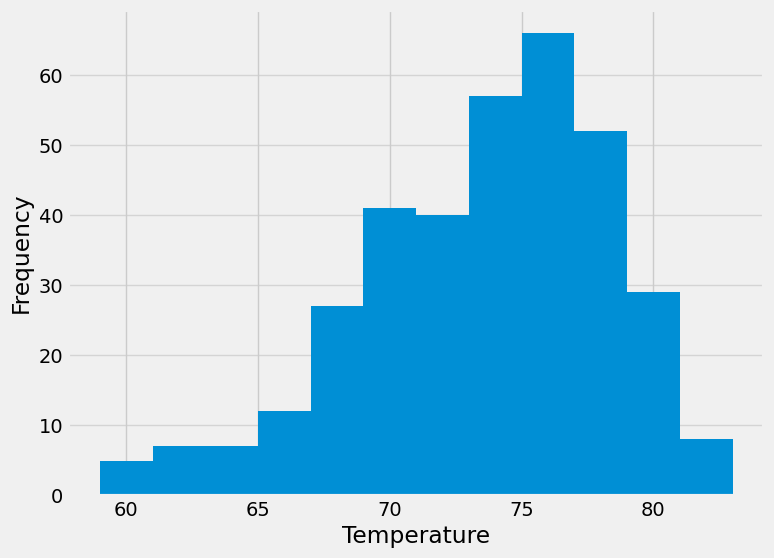

In [51]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate 12 months ago from the most recent date in the dataset
most_recent_date_row = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_date_row[0]
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Query to retrieve the temperature observations for the last 12 months for the most active station
temperature_data = session.query(Measurement.tobs) \
    .filter(and_(Measurement.station == most_active_station_id, Measurement.date >= one_year_ago)) \
    .all()

# Extract temperatures from the query results
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Close Session

In [52]:
# Close Session
session.close()